<a href="https://colab.research.google.com/github/Chirag314/EDA/blob/main/spaceship_titanic3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

######Reference 
https://www.kaggle.com/code/javigallego/titanic-spaceship-eda/notebook?scriptVersionId=90210061


In [464]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [465]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', 100)
pd.set_option('display.expand_frame_repr', False)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.max_columns', 500)
#pd.set_option('display.width', 1000)


from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
#from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
pd.set_option('max_rows',None)

In [466]:
#Helper functions

#Create function for missing data analysis
def draw_missing_data_table(df):
  total=df.isnull().sum().sort_values(ascending=False)
  percent=(df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  missing_data=pd.concat([total,percent],axis=1,keys=['Total','Percent'])
  return missing_data

In [467]:
#Plot learning curve
def plot_learning_curve(estimator, title, x,y,ylim=None, cv=None,n_jobs=1,train_sizes=np.linspace(.1,1,5)):
  plt.figure()
  plt.title(title)
  if ylim is not None:
    plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator,x,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean=np.mean(train_scores,axis=1)
    train_scores_std=np.std(train_scores,axis=1)
    test_scores_mean=np.mean(test_scores,axis=1)
    test_scores_std=np.std(test_scores,axis=1)
    plt.grid()
    plt.fill_between(train_sizes,train_scores_mean-train_scores_std,train_scores_mean+train_scores_std,alpha=0.1,color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color='r',label="Training score")
    plt.plot(train_sizes,test_scores_mean,'o-',color='g',label='Validation score')
    plt.legend(loc="best")
    return plt

In [468]:
#plot validation curve
def plot_validation_curve(estimator, title,x,y,param_name,param_range,ylim=None,cv=None,n_jobs=1,train_sizes=np.linspace(.1,1,5)):
  train_scores,test_scores=validation_curve(estimator,x,y,param_name,param_range,cv)
  train_mean=np.mean(train_scores,axis=1)
  train_std=np.std(train_scores,axis=1)
  test_mean=np.mean(test_scores,axis=1)
  test_std=np.std(test_scores,axis=1)
  plt.plot(param_range,train_mean,color='r',marker='o',markersize=5,label='Training Score')
  plt.fill_between(param_range,train_mean+train_std,train_mean-train_std,alpha=0.15,color='r')
  plt.plot(param_range,test_mean,color='g',linstyle='--',marker='s',markersize=5,label='Validation score')
  plt.fill_between(param_range, test_mean+test_std, test_mean-test_std,alpha=0.15,color='g')
  plt.grid()
  plt.xscale('log')
  plt.legend(loc='best')
  plt.xlabel('Parameter')
  plt.ylabel('Score')
  plt.ylim(ylim)

In [469]:
#get path from training and test data
curr_path = os.getcwd()
dataset_src=os.path.join(curr_path,'spaceship titanic')
train_path=os.path.join(dataset_src,'train.csv')
test_path=os.path.join(dataset_src,'test.csv')

In [470]:
#import data
train_df=pd.read_csv(train_path)
test_df=pd.read_csv(test_path)
df=pd.read_csv('train.csv')
df_raw=df.copy()
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Exploratory Data Analysis
Not all features provide necessary information for the model. It is essentil to find out important features for analysis.


In [471]:
# Check for missing values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [472]:
# Define the function that creates missing value heatmap
def plot_missing_data(dataset, title):
  fig,ax=plt.subplots(figsize=(5,5))
  plt.title(title)
  sns.heatmap(dataset,cbar=False)

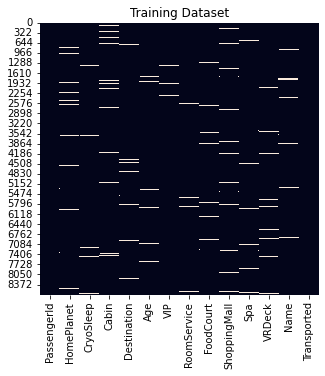

In [473]:
plot_missing_data(df.isnull(),"Training Dataset")

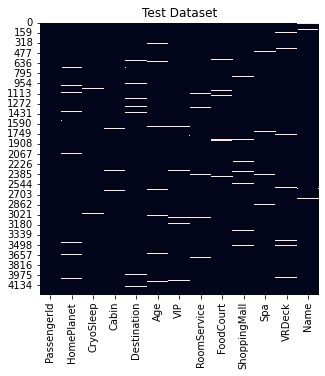

In [474]:
plot_missing_data(test_df.isnull(),"Test Dataset")

In [475]:
# Check number of  missing values in each columns
draw_missing_data_table(train_df)

,Total,Percent
CryoSleep,217,0.024963
ShoppingMall,208,0.023927
VIP,203,0.023352
HomePlanet,201,0.023122
Name,200,0.023007
Cabin,199,0.022892
VRDeck,188,0.021627
FoodCourt,183,0.021051
Spa,183,0.021051
Destination,182,0.020936


In [476]:
# Check features belonging to object category

train_df.select_dtypes(['object']).head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,False,Maham Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,False,Juanna Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,True,Altark Susent
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,False,Solam Susent
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,False,Willy Santantines


In [477]:
test_df.select_dtypes(['object']).head()
#test_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,VIP,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,False,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,False,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,False,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,False,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,False,Brence Harperez


In [478]:
# Impute missing values for Homeplanet
def filling_HomePlanet(df):
  mode=df['HomePlanet'].value_counts().index[0]
  df['HomePlanet']=df['HomePlanet'].fillna(mode)
  return df

In [479]:
# define function for imputing missing values of cryosleep
#if passenger had elected to put himself into suspended animation rarely it would have a missing value, we are going to consider the option of replacing missing values with False in this case.
def filling_CryoSleep(df):
  df['CryoSleep']=df['CryoSleep'].fillna(False)
  return df

######Cabin. As it is shown in the report this feature is categorical. As it is almost impossible to estimate cabin number for a passenger with given format, we are going to split cabin number into three different features. Those are going to be describing: desk, number and side. Thus, we'll start Feature Engineering here (continued in detail subsequently). Next, we are going to replace missing values for deck type feature with F (most repeated value). Hereafter, we are going to fill side feature with most repeated value into decks of type F. Finally, we are going to fill cabin number with half of the maximum cabin number (as cabins belonging to one deck type could have more survival rate whether they are one of the first/last cabin).

In [480]:
#Cabin

def split_Cabin(df):
    df['Deck'] = df['Cabin'].str.split("/", n=2, expand=True)[0]
    df['Number'] = df['Cabin'].str.split("/", n=2, expand=True)[1]
    df['Side'] = df['Cabin'].str.split("/", n=2, expand=True)[2]
    df.pop('Cabin')
    return df

def filling_cabin(df):
  df['Deck']=df['Deck'].fillna('F')
  mode=df[df.Deck=='F']['Side'].value_counts().index[0]
  df['Side']=mode
  df['Number']=df['Number'].astype(float)
  df['Number']=df['Number'].fillna(1976/2)
  return df

In [481]:
#trian_df=split_Cabin(train_df)
#train_df = filling_cabin(train_df)
#train_df.head()

In [482]:
# Destination. planet the passenger will be debarking to
# We will impute missing values with most repeated value

def filling_destination(df):
  mode=df['Destination'].value_counts().index[0]
  df['Destination']=df['Destination'].fillna(mode)
  return df

In [483]:
#VIP- weather the passenger has paid for special VIP service during the voyage
# VIP service deal has not been taken into data collection so replave missing values with faluse

def filling_vip(df):
  df['VIP']=df['VIP'].fillna(False)
  return df

In [484]:
#Name the first and last name of the passenger
# Replace missing values with none as name must be unique and we can not guess it

def filling_name(df):
  df['Name']=df['Name'].fillna('None')
  return df

In [485]:
# Define a function to call all categorical feature missing value imputation functions as defined above

def filling_categorical(df):
  df = filling_HomePlanet(df)
  df = filling_CryoSleep(df)
  df = split_Cabin(df)
  df = filling_cabin(df)
  df = filling_destination(df)
  df = filling_vip(df)
  df = filling_name(df)
  return df

In [486]:
# Check continuous features


In [487]:
train_df.select_dtypes(['float64']).head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,39.0,0.0,0.0,0.0,0.0,0.0
1,24.0,109.0,9.0,25.0,549.0,44.0
2,58.0,43.0,3576.0,0.0,6715.0,49.0
3,33.0,0.0,1283.0,371.0,3329.0,193.0
4,16.0,303.0,70.0,151.0,565.0,2.0


In [488]:
test_df.select_dtypes(['float64']).head()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
0,27.0,0.0,0.0,0.0,0.0,0.0
1,19.0,0.0,9.0,0.0,2823.0,0.0
2,31.0,0.0,0.0,0.0,0.0,0.0
3,38.0,0.0,6652.0,0.0,181.0,585.0
4,20.0,10.0,0.0,635.0,0.0,0.0


In [489]:
# Impute age with median

def filling_age(df):
  median = df['Age'].describe()[5]
  df['Age']=df['Age'].fillna(median)
  return df

In [490]:
# Impute all other luxury features
def filling_luxury_features(df):
  luxury_features=['RoomService', 'FoodCourt', 'ShoppingMall','Spa','VRDeck']
  df[luxury_features]=df[luxury_features].fillna(0)
  return df


In [491]:
# Impute all continuous features

def filling_numerical(df):
  df = filling_age(df)
  df = filling_luxury_features(df)
  return df

In [492]:
# Finallly create a function that calls both categorical and continuous function

def filling_missing(df):
  df = filling_categorical(df)
  df = filling_numerical(df)
  return df

# Call function on train data
train_df = filling_missing(train_df)
test_df= filling_missing(test_df)

In [493]:
draw_missing_data_table(test_df)

,Total,Percent
PassengerId,0,0.0
HomePlanet,0,0.0
CryoSleep,0,0.0
Destination,0,0.0
Age,0,0.0
VIP,0,0.0
RoomService,0,0.0
FoodCourt,0,0.0
ShoppingMall,0,0.0
Spa,0,0.0


In [494]:
# Feature engineering
# Base model

#def score_dataset(X, y, model=XGBRegressor(tree_method='gpu_hist', predictor='gpu_predictor'), model_2 = CatBoostRegressor(task_type = 'GPU', silent=True)):
#def score_dataset(X, y, model=XGBRegressor(), model_2 = CatBoostRegressor(silent=True)):
def score_dataset(x,y,model=XGBClassifier(label_encoder=False)):
    # Label encoding is good for XGBoost and RandomForest, but one-hot
    # would be better for models like Lasso or Ridge. The `cat.codes`
    # attribute holds the category levels.
    for colname in x.select_dtypes(["object","bool"]).columns:
        x[colname] = LabelEncoder().fit_transform(x[colname])
    y['Transported'] = LabelEncoder().fit_transform(y['Transported'])
    # Metric for Titanic SpaceShipt competition is MAE (Mean Absolute Error)
    score_xgb = cross_val_score(
        model, x, y, cv=5, scoring="accuracy", n_jobs=-1
    )
    
    score = score_xgb.mean()
    return score

x = train_df[train_df.Transported.isnull() == False].copy()
y = pd.DataFrame(x.pop('Transported'))
baseline_score = score_dataset(x, y)
print(f"Baseline score: {baseline_score:.5f} Accuracy")

Baseline score: 0.67549 Accuracy


In [495]:
# Modify Age feature and create new feature
train_df.Age=pd.qcut(train_df['Age'],10)
test_df.Age=pd.qcut(test_df['Age'],10)
test_df.head().style.set_properties(subset=['Age'], **{'background-color':'lightseagreen'})

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Number,Side
0,0013_01,Earth,True,TRAPPIST-1e,"(26.0, 29.0]",False,0.000000,0.000000,0.000000,0.000000,0.000000,Nelly Carsoning,G,3.000000,P
1,0018_01,Earth,False,TRAPPIST-1e,"(18.0, 21.0]",False,0.000000,9.000000,0.000000,2823.000000,0.000000,Lerome Peckers,F,4.000000,P
2,0019_01,Europa,True,55 Cancri e,"(29.0, 34.0]",False,0.000000,0.000000,0.000000,0.000000,0.000000,Sabih Unhearfus,C,0.000000,P
3,0021_01,Europa,False,TRAPPIST-1e,"(34.0, 40.0]",False,0.000000,6652.000000,0.000000,181.000000,585.000000,Meratz Caltilter,C,1.000000,P
4,0023_01,Earth,False,TRAPPIST-1e,"(18.0, 21.0]",False,10.000000,0.000000,635.000000,0.000000,0.000000,Brence Harperez,F,5.000000,P


In [496]:
# Family features

train_df[['Name','PassengerId']].head().style.set_properties(subset=['PassengerId'],**{'background-color':'lightgreen'})

,Name,PassengerId
0,Maham Ofracculy,0001_01
1,Juanna Vines,0002_01
2,Altark Susent,0003_01
3,Solam Susent,0003_02
4,Willy Santantines,0004_01


In [497]:
train_df['FamilyId'] = train_df['PassengerId'].str.split("_", n=2, expand=True)[0]
train_df['Family Name'] = train_df['Name'].str.split(' ', n=2, expand=True)[1]
train_df = train_df.set_index(['FamilyId','Family Name'])
train_df['Family Size'] = 1

for i in range(train_df.shape[0]):
    fam_size = train_df.loc[train_df.index[i],:].shape[0]
    train_df.loc[train_df.index[i],'Family Size'] = fam_size

train_df=train_df.reset_index()
train_df[['FamilyId','PassengerId','Family Name','Name','Family Size']].head().style.set_properties(subset=['FamilyId','Family Name','Family Size'], **{'background-color':'lightseagreen'})

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/ipykernel/zmqshell.py:537: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


,FamilyId,PassengerId,Family Name,Name,Family Size
0,0001,0001_01,Ofracculy,Maham Ofracculy,1
1,0002,0002_01,Vines,Juanna Vines,1
2,0003,0003_01,Susent,Altark Susent,2
3,0003,0003_02,Susent,Solam Susent,2
4,0004,0004_01,Santantines,Willy Santantines,1


In [498]:
# Do same for test_df
test_df['FamilyId'] = test_df['PassengerId'].str.split("_", n=2, expand=True)[0]
test_df['Family Name'] = test_df['Name'].str.split(' ', n=2, expand=True)[1]
test_df = test_df.set_index(['FamilyId','Family Name'])
test_df['Family Size'] = 1

for i in range(test_df.shape[0]):
    fam_size = test_df.loc[test_df.index[i],:].shape[0]
    test_df.loc[test_df.index[i],'Family Size'] = fam_size

test_df=test_df.reset_index()
test_df[['FamilyId','PassengerId','Family Name','Name','Family Size']].head().style.set_properties(subset=['FamilyId','Family Name','Family Size'], **{'background-color':'lightseagreen'})

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/ipykernel/zmqshell.py:537: PerformanceWarning: indexing past lexsort depth may impact performance.
  return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)


,FamilyId,PassengerId,Family Name,Name,Family Size
0,0013,0013_01,Carsoning,Nelly Carsoning,1
1,0018,0018_01,Peckers,Lerome Peckers,1
2,0019,0019_01,Unhearfus,Sabih Unhearfus,1
3,0021,0021_01,Caltilter,Meratz Caltilter,1
4,0023,0023_01,Harperez,Brence Harperez,1


In [499]:
#Boolean features encoding
boolean_col = train_df.select_dtypes(['bool']).columns
for i in range(len(boolean_col)):
  train_df[boolean_col[i]].replace([False,True],[0,1],inplace=True)

train_df['Transported'].replace([False,True],[0,1],inplace=True)
boolean_col = test_df.select_dtypes(['bool']).columns
for i in range(len(boolean_col)):
  test_df[boolean_col[i]].replace([False,True],[0,1],inplace=True)

In [500]:
test_df.head()

,FamilyId,Family Name,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Number,Side,Family Size
0,0013,Carsoning,0013_01,Earth,1,TRAPPIST-1e,"(26.0, 29.0]",0,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,G,3.0,P,1
1,0018,Peckers,0018_01,Earth,0,TRAPPIST-1e,"(18.0, 21.0]",0,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,F,4.0,P,1
2,0019,Unhearfus,0019_01,Europa,1,55 Cancri e,"(29.0, 34.0]",0,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,C,0.0,P,1
3,0021,Caltilter,0021_01,Europa,0,TRAPPIST-1e,"(34.0, 40.0]",0,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,C,1.0,P,1
4,0023,Harperez,0023_01,Earth,0,TRAPPIST-1e,"(18.0, 21.0]",0,10.0,0.0,635.0,0.0,0.0,Brence Harperez,F,5.0,P,1


In [501]:
# Categorical features encoding

for colname in train_df.drop('PassengerId',axis=1).select_dtypes(['object','category']).columns:
  train_df[colname]=LabelEncoder().fit_transform(train_df[colname])

In [502]:
train_df.head()

,FamilyId,Family Name,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Number,Side,Family Size
0,0,1431,0001_01,1,0,2,7,0,0.0,0.0,0.0,0.0,0.0,5252,0,1,0.0,0,1
1,1,2109,0002_01,0,0,2,3,0,109.0,9.0,25.0,549.0,44.0,4502,1,5,0.0,0,1
2,2,1990,0003_01,1,0,2,9,1,43.0,3576.0,0.0,6715.0,49.0,457,0,0,0.0,0,2
3,2,1990,0003_02,1,0,2,6,0,0.0,1283.0,371.0,3329.0,193.0,7150,0,0,0.0,0,2
4,3,1778,0004_01,0,0,2,1,0,303.0,70.0,151.0,565.0,2.0,8320,1,5,1.0,0,1


In [503]:
# Do for test data also

for colname in test_df.drop('PassengerId',axis=1).select_dtypes(['object','category']).columns:
  test_df[colname]=LabelEncoder().fit_transform(test_df[colname])

In [504]:
test_df.tail()

,FamilyId,Family Name,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Number,Side,Family Size
4272,3058,1209,9266_02,0,1,2,6,0,0.0,0.0,0.0,0.0,0.0,2105,6,1496.0,0,2
4273,3059,1401,9269_01,0,0,2,8,0,0.0,847.0,17.0,10.0,144.0,2654,5,988.0,0,1
4274,3060,1241,9271_01,2,1,0,4,0,0.0,0.0,0.0,0.0,0.0,2085,3,296.0,0,1
4275,3061,362,9273_01,1,0,2,4,0,0.0,2680.0,0.0,0.0,523.0,2327,3,297.0,0,1
4276,3062,948,9277_01,0,1,1,8,0,0.0,0.0,0.0,0.0,0.0,2439,6,1498.0,0,1


In [505]:
# Modelling
x_train= train_df[train_df.Transported.isnull()==False].drop(['Transported','PassengerId'],axis=1).copy()
y=pd.DataFrame(train_df[train_df.Transported.isnull()==False]
               ['Transported'].copy())

x_test=train_df[train_df.Transported.isnull()==True].drop(['Transported','PassengerId'],axis=1).copy()

for colname in x_train.select_dtypes(['object','bool']).columns:
  x_train[colname]=LabelEncoder().fit_transform(x_train[colname])

for colname in x_test.select_dtypes(['object','bool']).columns:
  x_train[colname]=LabelEncoder().fit_transform(x_test[colname])

y['Transported'] = LabelEncoder().fit_transform(y['Transported'])

model = XGBClassifier(label_encoder = False)
y=np.ravel(y)
y
model.fit(x_train,y)
pred=model.predict(x_test)



In [506]:
y = np.expand_dims(y, axis=1)
y.shape

(8693, 1)

In [507]:
x_train.shape

(8693, 17)

In [508]:
x_train=x_train.astype(float)
#train_df.describe()

In [509]:
#USe NN to predict survival rate
import tensorflow as tf
# Set random seed
tf.random.set_seed(42)

# Create a model
model_1 = tf.keras.Sequential([
  tf.keras.layers.Dense(60, activation=tf.keras.activations.relu), # hidden layer 1, ReLU activation
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(40, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation
 tf.keras.layers.Dense(20, activation=tf.keras.activations.relu), # hidden layer 2, ReLU activation 
  tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid) # ouput layer, sigmoid activation
])

# Compile the model
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.Adam(lr=0.001),
                metrics=['accuracy'], run_eagerly=True)

# Fit the model
history = model_1.fit(x_train, y, epochs=50)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
272/272 [==============================] - 5s 19ms/step - loss: 22.1119 - accuracy: 0.6030
Epoch 2/50
272/272 [==============================] - 5s 19ms/step - loss: 6.9594 - accuracy: 0.6383
Epoch 3/50
272/272 [==============================] - 5s 19ms/step - loss: 3.7288 - accuracy: 0.6440
Epoch 4/50
272/272 [==============================] - 5s 19ms/step - loss: 2.2792 - accuracy: 0.6604
Epoch 5/50
272/272 [==============================] - 5s 18ms/step - loss: 1.3419 - accuracy: 0.6745
Epoch 6/50
272/272 [==============================] - 5s 19ms/step - loss: 0.9958 - accuracy: 0.6757
Epoch 7/50
272/272 [==============================] - 5s 18ms/step - loss: 0.8763 - accuracy: 0.6784
Epoch 8/50
272/272 [==============================] - 5s 19ms/step - loss: 0.8170 - accuracy: 0.6738
Epoch 9/50
272/272 [==============================] - 5s 18ms/step - loss: 0.7013 - accuracy: 0.6885
Epoch 10/50
272/272 [==============================] - 5s 18ms/step - loss: 0.6875 - accur

In [510]:
model_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 60)                1080      
                                                                 
 dropout_9 (Dropout)         (None, 60)                0         
                                                                 
 dense_41 (Dense)            (None, 40)                2440      
                                                                 
 dense_42 (Dense)            (None, 20)                820       
                                                                 
 dense_43 (Dense)            (None, 1)                 21        
                                                                 
Total params: 4,361
Trainable params: 4,361
Non-trainable params: 0
_________________________________________________________________


In [511]:
test_df.shape

(4277, 18)

In [512]:

test_df.drop(['PassengerId'],axis=1,inplace=True)
test_df.shape

(4277, 17)

In [513]:
test_df=test_df.astype(float)
test_df.describe()

,FamilyId,Family Name,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Deck,Number,Side,Family Size
count,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.000000,4277.0,4277.000000
mean,1522.465747,866.564882,0.666823,0.361001,1.516016,4.405892,0.017302,215.062427,428.592238,173.233107,295.895955,304.898293,2104.881693,4.368716,619.012626,0.0,1.735562
std,888.630463,510.273831,0.809240,0.480347,0.801973,2.891286,0.130409,601.914503,1510.155974,554.991776,1104.872018,1235.991811,1198.957575,1.702467,512.104110,0.0,1.155570
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
25%,749.000000,424.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1064.000000,4.000000,179.000000,0.0,1.000000
50%,1515.000000,861.000000,0.000000,0.000000,2.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2132.000000,5.000000,463.000000,0.0,1.000000
75%,2293.000000,1307.000000,1.000000,1.000000,2.000000,7.000000,0.000000,48.000000,66.000000,27.000000,43.000000,31.000000,3107.000000,6.000000,1012.000000,0.0,2.000000
max,3062.000000,1725.000000,2.000000,1.000000,2.000000,9.000000,1.000000,11567.000000,25273.000000,8292.000000,19844.000000,22272.000000,4176.000000,7.000000,1890.000000,0.0,8.000000


In [514]:
pred=model_1.predict(test_df)
pred

array([[6.2503505e-01],
       [2.1549515e-05],
       [8.5863358e-01],
       ...,
       [7.5895506e-01],
       [7.3557341e-01],
       [8.0791509e-01]], dtype=float32)

In [515]:
test=pd.read_csv(test_path)
op=test[['PassengerId']]
op['Survived']=pred
op.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,PassengerId,Survived
0,0013_01,0.625035
1,0018_01,0.000022
2,0019_01,0.858634
3,0021_01,1.000000
4,0023_01,0.731791


In [516]:
op.loc[op['Survived'] < 0.5, 'Transported'] = 'False' 
op.loc[op['Survived'] >= 0.5, 'Transported'] = 'True' 
op.drop('Survived',axis=1,inplace=True)
op.head()

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [517]:
op.to_csv("Submission2.csv",index=False)

In [518]:
from sklearn.ensemble import GradientBoostingClassifier
gb=GradientBoostingClassifier()

gb.fit(x_train,y)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingClassifier()

In [524]:
pred_gb=gb.predict(test_df)


In [525]:
submit=pd.DataFrame({
    'PassengerId':test['PassengerId'],
    'Transported':pred_gb.astype('bool')
})
submit.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [526]:
submit.to_csv("Submission3.csv",index=False)